In [53]:
!pip install -q langchain huggingface-hub faiss-cpu transformers sentence-transformers
!pip install -q newsapi-python
!pip install -q langchain-community
!pip install -q openai==0.28
!pip install -q evaluate
!pip install -q rouge_score
!pip install -q gradio_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 5.2 MB/s eta 0:00:00


In [55]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineG

# Model Implementation

In [56]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
from langchain.vectorstores import FAISS
from faiss import IndexFlatIP
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain.embeddings import SentenceTransformerEmbeddings
import requests
from bs4 import BeautifulSoup
from newsapi import NewsApiClient
from huggingface_hub import InferenceClient
import openai
from langchain_core.documents import Document
from uuid import uuid4
from langchain_community.vectorstores.utils import DistanceStrategy
import time
from google.colab import userdata
from gradio_client import Client

In [57]:
class NormalizedEmbeddings:
    """
    A wrapper class for normalizing embeddings from a base model.
    This class provides methods to embed a single query or a list of documents,
    ensuring the resulting embeddings are normalized to unit vectors.
    """

    def __init__(self, base_model):
        """
        Initialize the NormalizedEmbeddings class.

        Args:
            base_model: An instance of a model that provides `embed_query`
                        and `embed_documents` methods to generate embeddings.
        """
        self.base_model = base_model

    def embed_query(self, query):
        """
        Generate and normalize the embedding for a single query.

        Args:
            query: The input query as a string.

        Returns:
            A normalized numpy array representing the query embedding.
        """
        embedding = np.array(self.base_model.embed_query(query))
        return embedding / np.linalg.norm(embedding)

    def embed_documents(self, documents):
        """
        Generate and normalize embeddings for a list of documents.

        Args:
            documents: A list of strings, each representing a document.

        Returns:
            A numpy array where each row is a normalized embedding for the
            corresponding document.
        """
        embeddings = np.array(self.base_model.embed_documents(documents))
        return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

In [79]:
class DualRagModel:
    """
    A dual RAG (Retrieval-Augmented Generation) model that leverages two
    separate vector databases: one for domain-specific, factual knowledge and
    one for contextual conversation history. This model retrieves relevant
    information from both sources to generate responses.
    """

    def __init__(self, model='llama', logging='quiet'):
        """
        Initialize the DualRagModel.

        Args:
            model (str): A text generation model, which can be one of "llama",
                         "gpt", or "mamba", responsible for generating responses.
            logging (str): A setting that controls the level of print statements.
                           Can be "quiet" (no output), "minimal" (essential
                           information only), or "verbose" (detailed logs).
        """
        self.logging = logging
        self.newsapi = NewsApiClient(api_key=userdata.get('NEWS_API_KEY'))
        self.seen_urls = set()

        embeddings = SentenceTransformerEmbeddings(model_name="all-mpnet-base-v2")
        self.normalized_embeddings = NormalizedEmbeddings(embeddings)
        dimensions: int = len(embeddings.embed_query("dummy"))

        self.knowledge_db = FAISS(
            embedding_function=self.normalized_embeddings.embed_query,
            index=IndexFlatIP(dimensions),  # Use inner product for cosine similarity
            docstore=InMemoryDocstore(),
            index_to_docstore_id={},
            distance_strategy=DistanceStrategy.MAX_INNER_PRODUCT
        )

        self.user_specific_db = FAISS(
            embedding_function=self.normalized_embeddings.embed_query,
            index=IndexFlatIP(dimensions),  # Use inner product for cosine similarity
            docstore=InMemoryDocstore(),
            index_to_docstore_id={},
            distance_strategy=DistanceStrategy.MAX_INNER_PRODUCT
        )

        self.model = model

        if model == 'llama':
            self.client = InferenceClient(api_key=userdata.get('HF_TOKEN'))
        elif model == 'mamba':
            self.client = Client("tiiuae/falcon-mamba-playground")

    def news_search(self, query):
        """
        Retrieve articles using the NewsAPI.

        Args:
            query (str): The search query to retrieve news articles.

        Returns:
            A list of articles, where each article is a dictionary containing
            details such as the title, description, source, publication date.
        """
        data = self.newsapi.get_everything(q=query,
                                           language='en',
                                           sort_by='relevancy',
                                           page_size=5)

        return data['articles']

    def fetch_full_content(self, url):
        """
        Fetch the full textual content from a given URL.

        Args:
            url (str): The URL of the webpage to fetch content from.

        Returns:
            A string containing the concatenated text content of all <p> tags on
            the page, or None if the content cannot be fetched due to an error.
        """
        try:
            response = requests.get(url)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, 'html.parser')
            paragraphs = soup.find_all('p')
            return '\n'.join([p.get_text() for p in paragraphs])
        except Exception as e:
            return None  # Return None if full content cannot be fetched


    def summarize_content_openAI(self, content):
        """
        Summarize the given content using OpenAI's GPT model.

        Args:
            content (str): A string containing the text to be summarized.

        Returns:
            A string representing the summarized content, or an error message
            if the summarization fails.
        """
        openai.api_key = userdata.get('OPENAI_API_KEY')

        try:
            response = openai.ChatCompletion.create(
                model="gpt-4o-mini",  # Specify the model
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": f"Summarize the content below in 150 words or less:\n{content}"}
                ],
                temperature=0.7,
                max_tokens=150
            )
            summary = response['choices'][0]['message']['content']
            return summary
        except Exception as e:
            return f"An error occurred: {e}"

    def update_knowledge_db(self, query):
        """
        Update the knowledge database with new information based on the query.

        Args:
            query (str): A string representing the search query used to retrieve relevant articles.
        """
        articles = self.news_search(query)
        documents = []

        for article in articles:
            if article['url'] not in self.seen_urls:
                self.seen_urls.add(article['url'])
                content = self.fetch_full_content(article['url'])
                if content:
                    summarized_content = self.summarize_content_openAI(content)

                    if self.logging == 'verbose':
                        print("GPT summary: ", summarized_content)

                    documents.append(Document(page_content=summarized_content, metadata={'source': 'news_api', 'timestamp': article['publishedAt'], 'search_timestamp': time.time()}))


        uuids = [str(uuid4()) for _ in range(len(documents))]

        if documents:
            self.knowledge_db.add_documents(documents=documents, ids=uuids)
            print("Knowledge database updated successfully!")

    def adaptive_retrieval(self, query):
        """
        Perform adaptive retrieval of information based on the given query.

        Args:
            query (str): A string representing the user's query.

        Returns:
            A combined list of factual and contextual results relevant to the query.
        """
        similar_context = self.user_specific_db.similarity_search_with_score(query, k=5)

        if similar_context:
            most_similar_context = similar_context[0] # Document object, similarity score
            for doc, score in similar_context:
                if score > 0.25 and doc.metadata['interaction_timestamp'] > most_similar_context[0].metadata['interaction_timestamp'] + 2:
                    most_similar_context = (doc, score)

            if most_similar_context[1] < 0.25: #be more generous with knowledge DB score threshold when context similarity is poor
                if self.logging != 'quiet':
                    print("AAAAAA")
                self.update_knowledge_db(query)

                if self.logging == 'verbose':
                    print("Most similar context score: ", most_similar_context[1])
                    test = self.knowledge_db.similarity_search_with_score(query, score_threshold=0.0, k=10)
                    print("Knowledge scores: ", [x[1] for x in test])

                factual_results = [x[0] for x in self.knowledge_db.similarity_search_with_score(query, score_threshold=0.25, k=10)]
            else:
                query = openai.ChatCompletion.create(
                    model="gpt-4o-mini",
                    messages=[
                        {"role": "system", "content": "Based on the context and query, generate up to 3 key words."},
                        {"role": "user", "content": f"Combine {query} with context from {most_similar_context[0]}"}
                    ],
                    temperature=0.7,
                    max_tokens=15
                )
                query = query['choices'][0]['message']['content']

                if self.logging != 'quiet':
                    print("BBBBBB")
                    print("GPT-created query: ", query)

                self.update_knowledge_db(query)

                if self.logging == 'verbose':
                    print("Most similar context score: ", most_similar_context[1])
                    test = self.knowledge_db.similarity_search_with_score(query, score_threshold=0.0, k=10)
                    print("Knowledge scores: ", [x[1] for x in test])

                sorted_factual_results = sorted(self.knowledge_db.similarity_search_with_score(query, score_threshold=0.4, k=10),
                                     key=lambda x: x[0].metadata["search_timestamp"],
                                     reverse=True)
                factual_results = [x[0] for x in sorted_factual_results]
        else:
            if self.logging != 'quiet':
                print("CCCCCC")

            self.update_knowledge_db(query)

            if self.logging == 'verbose':
                test = self.knowledge_db.similarity_search_with_score(query, score_threshold=0.0, k=10)
                print("Knowledge scores: ", [x[1] for x in test])

            factual_results = [x[0] for x in self.knowledge_db.similarity_search_with_score(query, score_threshold=0.25, k=10)]

        contextual_results = [x[0] for x in self.user_specific_db.similarity_search_with_score(query, score_threshold=0.3, k=10)]

        if self.logging == 'verbose':
            print("# of factual results:" , len(factual_results))
            print("# of contextual results: ", len(contextual_results))

        results = factual_results + contextual_results

        return results

    def update_user_memory(self, user_query, model_response):
        """
        Updates the user-specific database with the latest query and response.

        Args:
            user_query (str): The query provided by the user.
            model_response (str): The response generated by the model.
        """
        documents = []
        documents.append(Document(page_content=user_query + "\n" + model_response, metadata={'source': 'user_query', 'interaction_timestamp': time.time()}))
        uuids = [str(uuid4()) for _ in range(len(documents))]

        self.user_specific_db.add_documents(documents=documents, ids=uuids)
        print("User-specific memory updated successfully!")

    def generate_response(self, query):
        """
        Generate a response to the user's query based on relevant context from
        previous results using the generator specified when instantiating the model.

        Args:
            query (str): The user's question or query.

        Returns:
            A string containing the generated response to the query based on the context.
        """
        relevant_results = self.adaptive_retrieval(query)
        context = " ".join([result.page_content for result in relevant_results])

        if self.model == 'llama':
            input_prompt = f"Based on this context: {context}\n\nAnswer this question: {query}"

            messages = [
                {
                    "role": "user",
                    "content": input_prompt
                }
            ]

            completion = self.client.chat.completions.create(
                model="meta-llama/Meta-Llama-3-8B-Instruct",
                messages=messages,
                max_tokens=75
            )

            generated_response = completion.choices[0].message.content
            self.update_user_memory(query, generated_response)
            return generated_response

        elif self.model == 'gpt':
            generated_response = openai.ChatCompletion.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "Based on the context, answer the query."},
                    {"role": "user", "content": f"Based on this context: {context}\n\nAnswer this question: {query}"}
                ],
                temperature=0.7,
                max_tokens=75
            )

            generated_response = generated_response['choices'][0]['message']['content']
            self.update_user_memory(query, generated_response)
            return generated_response

        elif self.model == 'mamba':
            generated_response = self.client.predict(
                message=f"Based on this context: {context}\n\nAnswer this question: {query}",
                temperature=0.3,
                max_new_tokens=512,
                top_p=1,
                top_k=20,
                penalty=1.2,
                api_name="/chat"
            )
            self.update_user_memory(query, generated_response)
            return generated_response

# Example Conversation

In [57]:
model = DualRagModel(logging='verbose')

In [58]:
user_query_1 = 'who shot the UHC ceo'
model_response_1 = model.generate_response(user_query_1)

CCCCCC
GPT summary:  Following the fatal shooting of Brian Thompson, CEO of UnitedHealthcare, social media erupted with sharp commentary and dark humor rather than condolences. Users expressed their disdain for the health insurance industry, sharing memes and anecdotes about their negative experiences with insurers. A Facebook post from UnitedHealthcare received a staggering number of laughing emojis, prompting the company to disable comments. The reaction highlighted widespread frustration with the healthcare system, with many feeling that Thompson's death symbolized deeper systemic issues in American healthcare. Some even suggested that the health insurance industry's practices were indirectly responsible for numerous deaths. In response to the backlash, Anthem Blue Cross Blue Shield quickly rescinded a controversial coverage plan. The intense online reaction may indicate a growing public reckoning with the challenges posed by privatized health insurance in
GPT summary:  Luigi Mangio

In [59]:
print(model_response_1)

Luigi Mangione, a 26-year-old Ivy League graduate, has been arrested for the shooting death of UnitedHealthcare CEO Brian Thompson.


In [60]:
user_query_2 = 'where was he shot'
model_response_2 = model.generate_response(user_query_2)

BBBBBB
GPT-created query:  Shooting, UnitedHealthcare, Brian Thompson
GPT summary:  Brian Thompson, the CEO of UnitedHealthcare, was fatally shot in a targeted attack outside the Hilton Hotel in Midtown Manhattan on Wednesday morning. The incident occurred around 6:45 a.m., just before the company's annual investor conference was set to begin. Thompson, 50, was shot multiple times and pronounced dead shortly after arriving at the hospital. The assailant fled on an ebike, and while police are actively investigating, the suspect remains at large with conflicting witness descriptions complicating the search. Surveillance footage shows a figure wearing a hooded sweatshirt and a lighter-colored backpack. Mayor Eric Adams confirmed that the shooting does not appear to be random, and a $10,000 reward has been offered for information leading to the suspect's arrest.
GPT summary:  Claims that Brian Thompson, the CEO of UnitedHealthcare, was shot on December 4 because he was about to testify aga

In [61]:
print(model_response_2)

According to the article, Brian Thompson, the CEO of UnitedHealthcare, was shot outside the New York Hilton Midtown in Midtown Manhattan on Wednesday morning around 6:45 a.m.


In [62]:
user_query_3 = 'where was the suspect found'
model_response_3 = model.generate_response(user_query_3)

BBBBBB
GPT-created query:  Suspect, Location, Shooting
GPT summary:  Corpus Christi police have arrested 33-year-old Julian Rodriguez in connection to a fatal shooting outside a business on Thanksgiving Day. Officers responded to reports of the shooting at around 3 p.m. in the 5200 block of Interstate Highway 37, where they found a man in the parking lot who later died at a hospital. Rodriguez fled the scene, but detectives identified him and located him at a residence on Manchester Avenue later that evening. He attempted to evade capture but was apprehended by police. The two men involved were known to each other, and the police have not released the victim's identity or the name of the business. The investigation is ongoing, and authorities encourage anyone with information to contact the police or Crime Stoppers.
GPT summary:  Luigi Mangione, a 26-year-old Ivy League graduate from a wealthy Baltimore family, was arrested in Pennsylvania as the prime suspect in the targeted murder of

In [63]:
print(model_response_3)

According to the article, Luigi Mangione, the suspect, was arrested in Altoona, Pennsylvania, after being recognized at a McDonald's restaurant.


In [64]:
user_query_4 = 'how did people react'
model_response_4 = model.generate_response(user_query_4)

AAAAAA
GPT summary:  In the second episode of *Dune: Prophecy*, titled “Two Wolves,” tensions escalate as characters navigate their ambitions amid a backdrop of murder and political intrigue. Valya Harkonnen, a key player in the Sisterhood's quest for power, faces off against Desmond Hart, a mysterious figure with unique abilities, as both strive to manipulate the unfolding events. Following the violent deaths of key characters, the Sisterhood grapples with the implications of these losses, while Valya devises plans to secure a marriage alliance for Princess Ynez. Meanwhile, tensions rise within the Imperial court as Desmond’s influence grows, leading to confrontations with Valya. As Lila undergoes a perilous ritual, dark secrets emerge, including Valya
GPT summary:  The 2024 election marked a significant shift towards digital platforms, notably podcasts and YouTube, as key mediums for political engagement. Influential figures from traditional media, such as Tucker Carlson and Megyn Ke

In [65]:
print(model_response_4)

According to the text, people reacted with:

1. Sharp commentary and dark humor instead of condolences on social media, often expressing disdain for the health insurance industry and sharing memes and anecdotes about their negative experiences with insurers.
2. Laughing emojis and memes on a Facebook post from UnitedHealthcare, prompting the company to disable comments.
3. Negative reviews and creative A.I.


In [66]:
user_query_5 = 'when was president yoon impeached'
model_response_5 = model.generate_response(user_query_5)

AAAAAA
GPT summary:  South Korean lawmakers have impeached President Yoon Suk Yeol following his controversial attempt to impose martial law, which ignited widespread protests. The impeachment motion, supported by members of Yoon's own People Power Party (PPP) and opposition, passed with 204 votes in favor. Protesters celebrated outside the National Assembly, viewing the vote as a victory for democracy. Yoon, suspended from office, pledged to continue fighting, calling the vote a temporary setback. The constitutional court has 180 days to decide on the impeachment's validity. If upheld, a new presidential election must occur within 60 days. Prime Minister Han Duck-soo is now acting president amid ongoing police investigations into the events surrounding Yoon's martial law attempt. Public sentiment largely favors
GPT summary:  South Korean police are raiding the presidential office of President Yoon Suk Yeol amid political turmoil following his attempted martial law declaration. Althoug

In [67]:
print(model_response_5)

According to the text, President Yoon Suk Yeol was impeached by the National Assembly with 204 votes in favor, which passed following his controversial attempt to impose martial law.


In [68]:
user_query_6 = 'who impeached him'
model_response_6 = model.generate_response(user_query_6)

BBBBBB
GPT-created query:  Impeachment, Yoon Suk Yeol, National Assembly
GPT summary:  South Korean MPs have initiated impeachment proceedings against President Yoon Suk Yeol following his abrupt declaration of martial law, which he justified as a measure against North Korea's threats and domestic issues. The National Assembly was stormed by MPs who voted to block the martial law, with some reportedly breaking through barricades. Meanwhile, India’s economic growth shows signs of slowing despite remaining robust. Other global incidents include a devastating fire in the Philippines destroying around 1,000 homes, volcanic eruptions causing panic in Flores, and the successful landing of three astronauts from China’s Shenzhou-18 mission after six months in space. Additionally, a BBC investigation led to the rescue of a monkey from an online torture ring, while severe flooding near Chiang Mai prompted the evacuation
GPT summary:  South Korean President Yoon Suk Yeol has apologized for his re

In [69]:
print(model_response_6)

According to the text, South Korea's parliament (National Assembly) impeached President Yoon Suk Yeol.


In [70]:
user_query_7 = 'why was he impeached'
model_response_7 = model.generate_response(user_query_7)

BBBBBB
GPT-created query:  Impeachment, Yoon Suk Yeol, National Assembly
Most similar context score:  0.42207247
Knowledge scores:  [0.76112914, 0.7506474, 0.7434887, 0.7364797, 0.6711902, 0.6540861, 0.61717623, 0.550599, 0.5087712, 0.26338607]
# of factual results: 9
# of contextual results:  2
User-specific memory updated successfully!


In [71]:
print(model_response_7)

According to the text, President Yoon Suk Yeol was impeached by the National Assembly due to his controversial attempt to impose martial law, which sparked widespread protests and calls for his impeachment.


In [72]:
user_query_8 = 'what was the public reaction'
model_response_8 = model.generate_response(user_query_8)

BBBBBB
GPT-created query:  Impeachment, Martial Law, Protests
GPT summary:  South Korea's constitutional court is proceeding with the impeachment trial of President Yoon Suk Yeol, who was suspended for declaring martial law amid political unrest. Following a parliamentary vote for impeachment, widespread protests erupted, demanding Yoon's resignation. The court has six months to decide on Yoon's fate, with public hearings expected to take months, although there is pressure for a quick resolution. Prime Minister Han Duck-soo is currently acting as president. Yoon, who has not yet decided if he will testify, faces potential arrest for ignoring a summons from prosecutors. The ruling People Power Party (PPP) is reeling from the impeachment, leading to the resignation of its leader Han Dong-hoon and other Supreme Council members. If the court upholds the
GPT summary:  South Korean President Yoon Suk Yeol avoided impeachment after his ruling People Power Party (PPP) boycotted a vote aimed at

In [73]:
print(model_response_8)

According to the text, the public reaction to President Yoon Suk Yeol's impeachment was largely one of favor, with widespread protests and celebrations outside the National Assembly. Many citizens viewed the vote as a victory for democracy.


In [74]:
user_query_9 = 'what was the public reaction to the uhc shooting'
model_response_9 = model.generate_response(user_query_9)

BBBBBB
GPT-created query:  Public Reaction, UHC Shooting, Protests
Most similar context score:  0.48188865
Knowledge scores:  [0.5199699, 0.48004287, 0.4574015, 0.45619774, 0.44298798, 0.429627, 0.42686567, 0.4268387, 0.42229253, 0.41329944]
# of factual results: 10
# of contextual results:  4
User-specific memory updated successfully!


In [75]:
print(model_response_9)

According to the text, the public reaction to the shooting death of UnitedHealthcare CEO Brian Thompson was largely one of shock, outrage, and criticism of the health insurance industry, with many people expressing their disdain for the industry and sharing their negative experiences with insurers on social media.


# Testing with Test Dataset

In [6]:
import evaluate
import matplotlib.pyplot as plt

In [7]:
rouge = evaluate.load("rouge")

## LLaMa

### Single Topic Conversations

In [76]:
queries_1 = ["Who shot the UHC CEO?",
             "Where was he shot?",
             "Where was the suspect found?",
             "How did people react?"]
outputs_1 = []
labels_1 = ["Luigi Mangione, a 26 year old Ivy League graduate, shot Brian Thompson, the CEO of UnitedHealthcare",
            "Brian Thompson was shot in New York City in Midtown Manhattan outside of the Hilton hotel",
            "Luigi Mangione was found at a McDonald's restaurant in Altoona, Pennsylvania with a fake ID, firearm, and manifesto after being recognized",
            "People reacted with dark humor, critical commentary, sharing memes, jokes, and personal stories, criticism of the healthcare system, and anger and outrage towards health insurers"]

model_1 = DualRagModel(logging='quiet')

for query in queries_1:
    outputs_1.append(model_1.generate_response(query))

Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!


In [81]:
for output in outputs_1:
    print(output)

According to the text, the suspect who shot and killed UnitedHealthcare CEO Brian Thompson has not been identified yet, and the police have classified the shooting as a "premeditated, preplanned targeted attack".
According to the text, Brian Thompson was shot outside the Hilton Hotel in Midtown Manhattan.
According to the text, the suspect, Luigi Mangione, was arrested on December 9 in Altoona, Pennsylvania, after a week-long manhunt.
According to the text, people reacted to the murder of UnitedHealth CEO Brian Thompson in various ways, including:

* Expressing little sympathy for him on social media due to UnitedHealth's history of denying health insurance claims
* Viewing the killing as a form of vigilante justice, reflecting widespread anger over healthcare injustices, particularly during the COVID-19 pandemic when many claims were


In [80]:
rouge_scores_1 = rouge.compute(predictions=outputs_1, references=labels_1)

print("ROUGE Scores:")
for key, value in rouge_scores_1.items():
    print(f"{key}: {value:.4f}")

ROUGE Scores:
rouge1: 0.3841
rouge2: 0.1863
rougeL: 0.2812
rougeLsum: 0.2812


In [83]:
queries_2 = ['When was President Yoon impeached',
             'Who impeached him',
             'Why was he impeached',
             'What was the public’s reaction']
outputs_2 = []
labels_2 = ['President Yoon Suk Yeol was impeached on December 14, 2024.',
            'South Korean lawmakers in the National Assembly impeached President Yoon Suk Yeol.',
            'President Yoon Suk Yeol was impeached due to his declaration of martial law.',
            'There were widespread protests. Thousands of protestors celebrated the result of the impeachment vote and viewed it as a victory for democracy.']

model_2 = DualRagModel(logging='quiet')

for query in queries_2:
    outputs_2.append(model_2.generate_response(query))

Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!


In [96]:
for output in outputs_2:
    print(output)

According to the context, the impeachment of President Yoon Suk Yeol has been passed by the South Korean lawmakers, but the question of whether the impeachment is being upheld or not is still pending. The constitutional court now has 180 days to decide on the impeachment, and if upheld, a new presidential election must occur within 60 days. Therefore, it is not clear when
According to the context, South Korean lawmakers impeached President Yoon Suk Yeol over his attempt to impose martial law, which led to widespread protests.
According to the context, President Yoon Suk Yeol was impeached for his brief imposition of martial law on December 3, which led to widespread protests and calls for his resignation.
According to the context, the public's reaction was one of widespread protests and calls for Yoon's resignation. Thousands of anti-Yoon protesters celebrated outside the National Assembly following the vote to impeach Yoon. The protests were sparked by Yoon's declaration of martial la

In [84]:
rouge_scores_2 = rouge.compute(predictions=outputs_2, references=labels_2)

print("ROUGE Scores:")
for key, value in rouge_scores_2.items():
    print(f"{key}: {value:.4f}")

ROUGE Scores:
rouge1: 0.3646
rouge2: 0.2078
rougeL: 0.3131
rougeLsum: 0.3131


In [85]:
queries_3 = ['When was Trump’s first conference after the election held',
             'Who did he nominate as attorney general',
             'Who did he nominate for Secretary of State',
             'Who is he replacing as president',
             'What top executives has he met with or will meet',
             'What did he say in the conference']
outputs_3 = []
labels_3 = ['Donald Trump’s first press conference after the election was held at Mar-a-Lago.',
            'Donald Trump nominated Pam Bondi for attorney general.',
            'Donald Trump nominated Marco Rubio for Secretary of State.',
            'Donald Trump is replacing Joe Biden as president.',
            'Donald Trump will meet with Mark Zuckerburg, Tim Cook, Sundar Pichai, and Jeff Bezos.',
            "He discussed SoftBank's $100 billion investment plan in U.S. projects, the Ukraine war, border wall construction and potential legal action, New York Mayor Eric Adams' legal troubles, his transition process and meetings with business leaders, and drones in New Jersey."]

model_3 = DualRagModel(logging='quiet')

for query in queries_3:
    outputs_3.append(model_3.generate_response(query))

Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!


In [97]:
for output in outputs_3:
    print(output)

The article does not specify when Trump's conference was held, but it mentions that it was a "recent" event, and that the article was published after Trump's presidential victory. Therefore, we cannot pinpoint an exact date for the conference.
According to the article, President-elect Donald Trump initially nominated Matt Gaetz for Attorney General, but Gaetz withdrew his nomination due to controversies surrounding allegations of sex trafficking and drug use. Then, Trump nominated Pam Bondi, a veteran prosecutor and former Florida attorney general, for the role.
According to the article, President-elect Donald Trump nominated Marco Rubio as Secretary of State.
The article does not specify who Trump is replacing as president, but it is implied that he is succeeding President Biden, as it mentions that Trump has been selecting cabinet members and making announcements about his administration.
According to the article, President-elect Donald Trump has selected a list of top executives for

In [86]:
rouge_scores_3 = rouge.compute(predictions=outputs_3, references=labels_3)

print("ROUGE Scores:")
for key, value in rouge_scores_3.items():
    print(f"{key}: {value:.4f}")

ROUGE Scores:
rouge1: 0.2802
rouge2: 0.1702
rougeL: 0.2498
rougeLsum: 0.2481


In [87]:
queries_4 = ['Why have drones been in the headlines',
             'Were they deployed by the US military',
             'Are they a threat']
outputs_4 = []
labels_4 = ['There have been sightings of mysterious drones flying over New Jersey at night. There is no evidence of malicious activity or foreign involvement.',
            'No they are not military drones.',
            'The drones are not a threat to public safety or national security. Most of the sightings are misidentified legal aircraft and stars.']

model_4 = DualRagModel(logging='quiet')

for query in queries_4:
    outputs_4.append(model_4.generate_response(query))

Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!


In [98]:
for output in outputs_4:
    print(output)

According to the text, drones have been in the headlines because of recent sightings in New Jersey and neighboring states, which have been attributed to misidentified legal aircraft and stars, posing no threat to safety. The incidents have led to a surge in public speculation and conspiracy theories, prompting politicians to demand clarity and action from federal authorities.
No, the information in the text does not suggest that the North Korean troops were deployed by the US military. According to the text, the North Korean troops were sent to support Russia's war efforts in Ukraine, and were reported to be fighting alongside Russian forces in the Kursk region. There is no mention of the US military deploying the North Korean troops.
According to the text, the Federal agencies, including the Department of Homeland Security and the FBI, have concluded that recent drone sightings over New Jersey and surrounding states are likely misidentified legal aircraft and stars, posing no threat t

In [88]:
rouge_scores_4 = rouge.compute(predictions=outputs_4, references=labels_4)

print("ROUGE Scores:")
for key, value in rouge_scores_4.items():
    print(f"{key}: {value:.4f}")

ROUGE Scores:
rouge1: 0.2531
rouge2: 0.0934
rougeL: 0.1838
rougeLsum: 0.1838


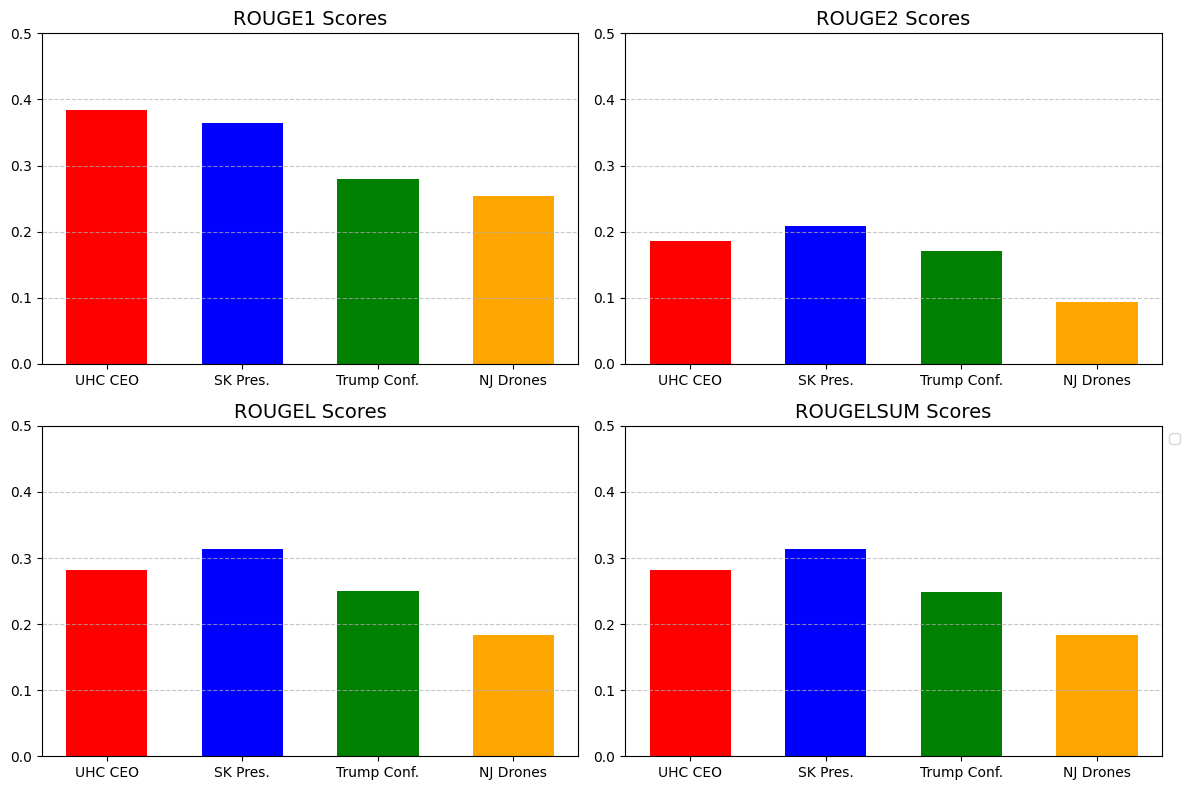

In [93]:
rouge_scores = [rouge_scores_1, rouge_scores_2, rouge_scores_3, rouge_scores_4]

keys = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
values = {key: [d[key] for d in rouge_scores] for key in keys}

topics = ['UHC CEO', 'SK Pres.', 'Trump Conf.', 'NJ Drones']

x = np.arange(len(rouge_scores))
bar_width = 0.4

colors = ['red', 'blue', 'green', 'orange']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

x = np.arange(len(rouge_scores))

for i, key in enumerate(keys):
    ax = axes[i]
    for j in range(len(rouge_scores)):
        ax.bar(
            x[j],
            values[key][j],
            color=colors[j],
            width=0.6,
            label=f'Set {j+1}' if i == 0 else ""
        )
    ax.set_title(f'{key.upper()} Scores', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([topic for topic in topics])
    ax.set_ylim(0, 0.5)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    if i == 3:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

### Double Topic Conversations

In [11]:
queries_5 = ["Who shot the UHC CEO?",
             "Where was he shot?",
             "Where was the suspect found?",
             "How did people react?",
             'When was President Yoon impeached',
             'Who impeached him',
             'Why was he impeached',
             'What was the public’s reaction']
outputs_5 = []
labels_5 = ["Luigi Mangione, a 26 year old Ivy League graduate, shot Brian Thompson, the CEO of UnitedHealthcare",
            "Brian Thompson was shot in New York City in Midtown Manhattan outside of the Hilton hotel",
            "Luigi Mangione was found at a McDonald's restaurant in Altoona, Pennsylvania with a fake ID, firearm, and manifesto after being recognized",
            "People reacted with dark humor, critical commentary, sharing memes, jokes, and personal stories, criticism of the healthcare system, and anger and outrage towards health insurers",
            'President Yoon Suk Yeol was impeached on December 14, 2024.',
            'South Korean lawmakers in the National Assembly impeached President Yoon Suk Yeol.',
            'President Yoon Suk Yeol was impeached due to his declaration of martial law.',
            'There were widespread protests. Thousands of protestors celebrated the result of the impeachment vote and viewed it as a victory for democracy.']

model_5 = DualRagModel(logging='quiet')

for query in queries_5:
    outputs_5.append(model_5.generate_response(query))

Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!


In [12]:
for output in outputs_5:
    print(output)

According to the text, Luigi Mangione is suspected of shooting Brian Thompson, the CEO of UnitedHealthcare.
According to the text, Brian Thompson, the CEO of UnitedHealthcare, was shot multiple times outside the New York Hilton Midtown on December 4.
According to the text, Luigi Mangione, the suspected murderer, was arrested at a McDonald's in Altoona, Pennsylvania.
According to the article, people's reactions to the murder of Brian Thompson and the subsequent arrest of Luigi Mangione were varied and complex. Some themes and reactions that emerged include:

* Some people, including supporters of Mangione, expressed admiration for him and criticized the healthcare system, seeing him as a "folk hero" or a "vigilante" who took action against a
The article does not specify the date when President Yoon was impeached. It only mentions that the impeachment motion passed, and that the constitutional court has 180 days to decide on the impeachment, which could lead to new presidential elections

In [13]:
rouge_scores_5 = rouge.compute(predictions=outputs_5, references=labels_5)

print("ROUGE Scores:")
for key, value in rouge_scores_5.items():
    print(f"{key}: {value:.4f}")

ROUGE Scores:
rouge1: 0.3834
rouge2: 0.2172
rougeL: 0.3256
rougeLsum: 0.3369


In [14]:
queries_6 = ['When was President Yoon impeached',
             'Who impeached him',
             'Why was he impeached',
             'What was the public’s reaction',
             'When was Trump’s first conference after the election held',
             'Who did he nominate as attorney general',
             'Who did he nominate for Secretary of State',
             'Who is he replacing as president',
             'What top executives has he met with or will meet',
             'What did he say in the conference']
outputs_6 = []
labels_6 = ['President Yoon Suk Yeol was impeached on December 14, 2024.',
            'South Korean lawmakers in the National Assembly impeached President Yoon Suk Yeol.',
            'President Yoon Suk Yeol was impeached due to his declaration of martial law.',
            'There were widespread protests. Thousands of protestors celebrated the result of the impeachment vote and viewed it as a victory for democracy.',
            'Donald Trump’s first press conference after the election was held at Mar-a-Lago.',
            'Donald Trump nominated Pam Bondi for attorney general.',
            'Donald Trump nominated Marco Rubio for Secretary of State.',
            'Donald Trump is replacing Joe Biden as president.',
            'Donald Trump will meet with Mark Zuckerburg, Tim Cook, Sundar Pichai, and Jeff Bezos.',
            "He discussed SoftBank's $100 billion investment plan in U.S. projects, the Ukraine war, border wall construction and potential legal action, New York Mayor Eric Adams' legal troubles, his transition process and meetings with business leaders, and drones in New Jersey."]

model_6 = DualRagModel(logging='quiet')

for query in queries_6:
    outputs_6.append(model_6.generate_response(query))

Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!


In [15]:
for output in outputs_6:
    print(output)

According to the context, President Yoon Suk Yeol's impeachment was supported by some members of his own People Power Party (PPP), and the motion to pass with 204 votes in favor.
According to the context, President Yoon Suk Yeol was impeached by the South Korean lawmakers.
According to the context, President Yoon Suk Yeol was impeached due to his attempt to impose martial law, which sparked widespread protests and was opposed by both his own ruling party and the opposition party, the Democratic Party.
According to the context, the public's reaction was overwhelmingly against President Yoon Suk Yeol. The passage states that "public sentiment largely favors the impeachment" and that "three-quarters of South Koreans support his ousting." Additionally, there were thousands of anti-Yoon demonstrators celebrating outside the National Assembly after the impeachment vote, expressing their desire for his removal.
The context does not mention Trump's first conference after the election, but rath

In [16]:
rouge_scores_6 = rouge.compute(predictions=outputs_6, references=labels_6)

print("ROUGE Scores:")
for key, value in rouge_scores_6.items():
    print(f"{key}: {value:.4f}")

ROUGE Scores:
rouge1: 0.3571
rouge2: 0.2349
rougeL: 0.3066
rougeLsum: 0.3084


In [17]:
queries_7 = ['When was Trump’s first conference after the election held',
             'Who did he nominate as attorney general',
             'Who did he nominate for Secretary of State',
             'Who is he replacing as president',
             'What top executives has he met with or will meet',
             'What did he say in the conference',
             'Why have drones been in the headlines',
             'Were they deployed by the US military',
             'Are they a threat']
outputs_7 = []
labels_7 = ['Donald Trump’s first press conference after the election was held at Mar-a-Lago.',
            'Donald Trump nominated Pam Bondi for attorney general.',
            'Donald Trump nominated Marco Rubio for Secretary of State.',
            'Donald Trump is replacing Joe Biden as president.',
            'Donald Trump will meet with Mark Zuckerburg, Tim Cook, Sundar Pichai, and Jeff Bezos.',
            "He discussed SoftBank's $100 billion investment plan in U.S. projects, the Ukraine war, border wall construction and potential legal action, New York Mayor Eric Adams' legal troubles, his transition process and meetings with business leaders, and drones in New Jersey.",
            'There have been sightings of mysterious drones flying over New Jersey at night. There is no evidence of malicious activity or foreign involvement.',
            'No they are not military drones.',
            'The drones are not a threat to public safety or national security. Most of the sightings are misidentified legal aircraft and stars.']

model_7 = DualRagModel(logging='quiet')

for query in queries_7:
    outputs_7.append(model_7.generate_response(query))

Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!


In [18]:
for output in outputs_7:
    print(output)

The article does not mention a specific conference held by Trump after the election. It actually talks about the "Harvard's Campaign Managers Conference" where Trump's campaign aides mocked the performance of Kamala Harris and Joe Biden's team after their electoral defeat.
According to the article, Donald Trump initially nominated Matt Gaetz as attorney general, but later withdrew the nomination due to controversy surrounding allegations against Gaetz. Trump then nominated Pam Bondi, former Florida Attorney General, as his new nominee for attorney general.
According to the article, Donald Trump nominated Marco Rubio as Secretary of State.
According to the article, it is not mentioned who Donald Trump is replacing as President. The context of the article suggests that Trump is planning for his second term as President, not replacing a sitting President.
The article does not mention Donald Trump meeting with or planning to meet specific top executives.
According to the article, Apple CEO

In [19]:
rouge_scores_7 = rouge.compute(predictions=outputs_7, references=labels_7)

print("ROUGE Scores:")
for key, value in rouge_scores_7.items():
    print(f"{key}: {value:.4f}")

ROUGE Scores:
rouge1: 0.3097
rouge2: 0.1762
rougeL: 0.2722
rougeLsum: 0.2716


In [20]:
queries_8 = ['Why have drones been in the headlines',
             'Were they deployed by the US military',
             'Are they a threat',
             "Who shot the UHC CEO?",
             "Where was he shot?",
             "Where was the suspect found?",
             "How did people react?"]
outputs_8 = []
labels_8 = ['There have been sightings of mysterious drones flying over New Jersey at night. There is no evidence of malicious activity or foreign involvement.',
            'No they are not military drones.',
            'The drones are not a threat to public safety or national security. Most of the sightings are misidentified legal aircraft and stars.',
            "Luigi Mangione, a 26 year old Ivy League graduate, shot Brian Thompson, the CEO of UnitedHealthcare",
            "Brian Thompson was shot in New York City in Midtown Manhattan outside of the Hilton hotel",
            "Luigi Mangione was found at a McDonald's restaurant in Altoona, Pennsylvania with a fake ID, firearm, and manifesto after being recognized",
            "People reacted with dark humor, critical commentary, sharing memes, jokes, and personal stories, criticism of the healthcare system, and anger and outrage towards health insurers"]

model_8 = DualRagModel(logging='quiet')

for query in queries_8:
    outputs_8.append(model_8.generate_response(query))

Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!


In [21]:
for output in outputs_8:
    print(output)

Drones have been in the headlines due to recent sightings over the East Coast, specifically in New Jersey and surrounding states, which have sparked widespread speculation, conspiracy theories, and public concern. While the government has downplayed the threat, citing most sightings as benign and involving commercial or hobbyist drones, the situation has prompted calls for increased transparency and legislative action from state officials. The
No, the North Korean soldiers were not deployed by the US military. According to the text, they were deployed by Russia to support its war effort in Ukraine. Specifically, it is reported that North Korea sent approximately 10,000 troops to support Russia's war effort, and later, as many as 12,000 North Korean troops have already been deployed, with potential numbers
According to the text, the government and law enforcement agencies have concluded that the drones do not pose a national security risk or malicious activity, and that most sightings a

In [22]:
rouge_scores_8 = rouge.compute(predictions=outputs_8, references=labels_8)

print("ROUGE Scores:")
for key, value in rouge_scores_8.items():
    print(f"{key}: {value:.4f}")

ROUGE Scores:
rouge1: 0.3375
rouge2: 0.1187
rougeL: 0.2592
rougeLsum: 0.2601


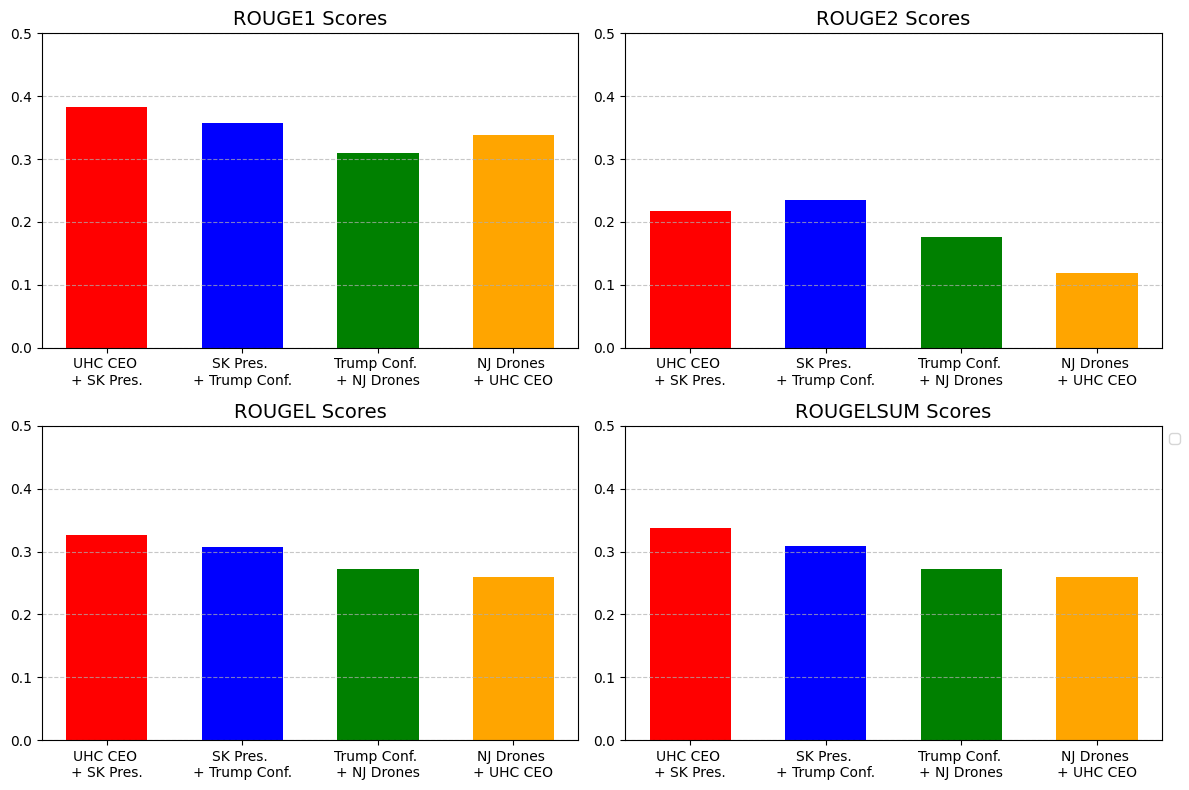

In [25]:
rouge_scores = [rouge_scores_5, rouge_scores_6, rouge_scores_7, rouge_scores_8]

keys = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
values = {key: [d[key] for d in rouge_scores] for key in keys}

topics = ['UHC CEO \n+ SK Pres.', 'SK Pres. \n+ Trump Conf.', 'Trump Conf. \n+ NJ Drones', 'NJ Drones \n+ UHC CEO']

x = np.arange(len(rouge_scores))
bar_width = 0.4

colors = ['red', 'blue', 'green', 'orange']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

x = np.arange(len(rouge_scores))

for i, key in enumerate(keys):
    ax = axes[i]
    for j in range(len(rouge_scores)):
        ax.bar(
            x[j],
            values[key][j],
            color=colors[j],
            width=0.6,
            label=f'Set {j+1}' if i == 0 else ""
        )
    ax.set_title(f'{key.upper()} Scores', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([topic for topic in topics])
    ax.set_ylim(0, 0.5)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    if i == 3:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## GPT

### Single Topic Conversations

In [29]:
queries_1 = ["Who shot the UHC CEO?",
             "Where was he shot?",
             "Where was the suspect found?",
             "How did people react?"]
outputs_1 = []
labels_1 = ["Luigi Mangione, a 26 year old Ivy League graduate, shot Brian Thompson, the CEO of UnitedHealthcare",
            "Brian Thompson was shot in New York City in Midtown Manhattan outside of the Hilton hotel",
            "Luigi Mangione was found at a McDonald's restaurant in Altoona, Pennsylvania with a fake ID, firearm, and manifesto after being recognized",
            "People reacted with dark humor, critical commentary, sharing memes, jokes, and personal stories, criticism of the healthcare system, and anger and outrage towards health insurers"]

model_1 = DualRagModel(logging='quiet', model='gpt')

for query in queries_1:
    outputs_1.append(model_1.generate_response(query))

Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!


In [30]:
for output in outputs_1:
    print(output)

The UnitedHealthcare CEO, Brian Thompson, was shot by Luigi Mangione.
Brian Thompson was shot outside a hotel in Manhattan, specifically the New York Hilton Midtown Hotel.
The suspect, Luigi Mangione, was found at a McDonald's in Altoona, Pennsylvania.
People reacted with a mix of dark humor and scathing commentary on social media, expressing widespread anger towards health insurers rather than offering condolences for Brian Thompson's murder. Many shared jokes and memes, indicating their frustration with the healthcare system. Reactions to UnitedHealthcare's statement included laughing emojis, reflecting a sense of "karma" for the company’s history of denying claims that many believe


In [31]:
rouge_scores_1 = rouge.compute(predictions=outputs_1, references=labels_1)

print("ROUGE Scores:")
for key, value in rouge_scores_1.items():
    print(f"{key}: {value:.4f}")

ROUGE Scores:
rouge1: 0.6141
rouge2: 0.2902
rougeL: 0.3973
rougeLsum: 0.3973


In [33]:
queries_2 = ['When was President Yoon impeached',
             'Who impeached him',
             'Why was he impeached',
             'What was the public’s reaction']
outputs_2 = []
labels_2 = ['President Yoon Suk Yeol was impeached on December 14, 2024.',
            'South Korean lawmakers in the National Assembly impeached President Yoon Suk Yeol.',
            'President Yoon Suk Yeol was impeached due to his declaration of martial law.',
            'There were widespread protests. Thousands of protestors celebrated the result of the impeachment vote and viewed it as a victory for democracy.']

model_2 = DualRagModel(logging='quiet', model='gpt')

for query in queries_2:
    outputs_2.append(model_2.generate_response(query))

Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!


In [34]:
for output in outputs_2:
    print(output)

President Yoon Suk Yeol was impeached by South Korean lawmakers on a date not explicitly mentioned in the provided context. However, it is implied that the impeachment occurred shortly after his controversial declaration of martial law, which he lifted within hours amid protests. For a specific date, further information outside of the provided context would be needed.
President Yoon Suk Yeol was impeached by South Korea's National Assembly.
President Yoon Suk Yeol was impeached primarily due to his controversial declaration of martial law, which was viewed as an overreach of power and sparked widespread protests. He issued the martial law decree in response to rising tensions, claiming it was necessary to preserve order and combat "anti-state forces." However, the decree led to public outcry, accusations of rebellion, and a
The public's reaction to President Yoon Suk Yeol's declaration of martial law was one of widespread protest and outrage. Many citizens expressed distrust in his lea

In [35]:
rouge_scores_2 = rouge.compute(predictions=outputs_2, references=labels_2)

print("ROUGE Scores:")
for key, value in rouge_scores_2.items():
    print(f"{key}: {value:.4f}")

ROUGE Scores:
rouge1: 0.3567
rouge2: 0.1979
rougeL: 0.2506
rougeLsum: 0.2506


In [44]:
queries_3 = ['When was Trump’s first conference after the election held',
             'Who did he nominate as attorney general',
             'Who did he nominate for Secretary of State',
             'Who is he replacing as president',
             'What top executives has he met with or will meet',
             'What did he say in the conference']
outputs_3 = []
labels_3 = ['Donald Trump’s first press conference after the election was held at Mar-a-Lago.',
            'Donald Trump nominated Pam Bondi for attorney general.',
            'Donald Trump nominated Marco Rubio for Secretary of State.',
            'Donald Trump is replacing Joe Biden as president.',
            'Donald Trump will meet with Mark Zuckerburg, Tim Cook, Sundar Pichai, and Jeff Bezos.',
            "He discussed SoftBank's $100 billion investment plan in U.S. projects, the Ukraine war, border wall construction and potential legal action, New York Mayor Eric Adams' legal troubles, his transition process and meetings with business leaders, and drones in New Jersey."]

model_3 = DualRagModel(logging='quiet', model='gpt')

for query in queries_3:
    outputs_3.append(model_3.generate_response(query))

Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!


In [45]:
for output in outputs_3:
    print(output)

The context provided does not specify the exact date of Trump's first conference after the election. It mentions events related to the Campaign Managers Conference at Harvard University and discusses various aspects of Trump's campaign and strategies, but it does not provide a timeline for specific conferences. Therefore, based on the information given, I cannot determine when Trump's first conference after the election was held.
Donald Trump nominated Pam Bondi as Attorney General following Matt Gaetz's withdrawal from the position.
The provided context does not mention who Donald Trump nominated for Secretary of State.
Donald Trump is replacing President Joe Biden as president.
The provided context does not specify which top executives Donald Trump has met with or will meet.
In the conference, President-elect Donald Trump expressed optimism about improved relations with former adversaries, particularly tech CEOs. He stated, “Everybody wants to be my friend,” indicating a shift in att

In [46]:
rouge_scores_3 = rouge.compute(predictions=outputs_3, references=labels_3)

print("ROUGE Scores:")
for key, value in rouge_scores_3.items():
    print(f"{key}: {value:.4f}")

ROUGE Scores:
rouge1: 0.4786
rouge2: 0.3435
rougeL: 0.4592
rougeLsum: 0.4536


In [47]:
queries_4 = ['Why have drones been in the headlines',
             'Were they deployed by the US military',
             'Are they a threat']
outputs_4 = []
labels_4 = ['There have been sightings of mysterious drones flying over New Jersey at night. There is no evidence of malicious activity or foreign involvement.',
            'No they are not military drones.',
            'The drones are not a threat to public safety or national security. Most of the sightings are misidentified legal aircraft and stars.']

model_4 = DualRagModel(logging='quiet', model='gpt')

for query in queries_4:
    outputs_4.append(model_4.generate_response(query))

Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!
Knowledge database updated successfully!
User-specific memory updated successfully!


In [48]:
for output in outputs_4:
    print(output)

Drones have been in the headlines due to a significant increase in reported sightings along the East Coast, particularly in states like New Jersey and New York. President Biden addressed these sightings, asserting that they pose no threat and are mostly attributed to commercial, hobbyist, and law enforcement drones. The government has received over 5,000 reports, many of which were misidentified aircraft
No, the drones reported in the recent sightings were not deployed by the US military. The sightings are primarily attributed to commercial, hobbyist, and law enforcement drones, according to government officials. The Pentagon and federal agencies have found no evidence of malicious activity or foreign involvement related to these drones.
According to government officials, the drones reported in the recent sightings are not considered a threat. President Biden and federal agencies, including the FBI and Department of Homeland Security, have stated that the drones are primarily attribute

In [49]:
rouge_scores_4 = rouge.compute(predictions=outputs_4, references=labels_4)

print("ROUGE Scores:")
for key, value in rouge_scores_4.items():
    print(f"{key}: {value:.4f}")

ROUGE Scores:
rouge1: 0.2378
rouge2: 0.0556
rougeL: 0.1794
rougeLsum: 0.1794


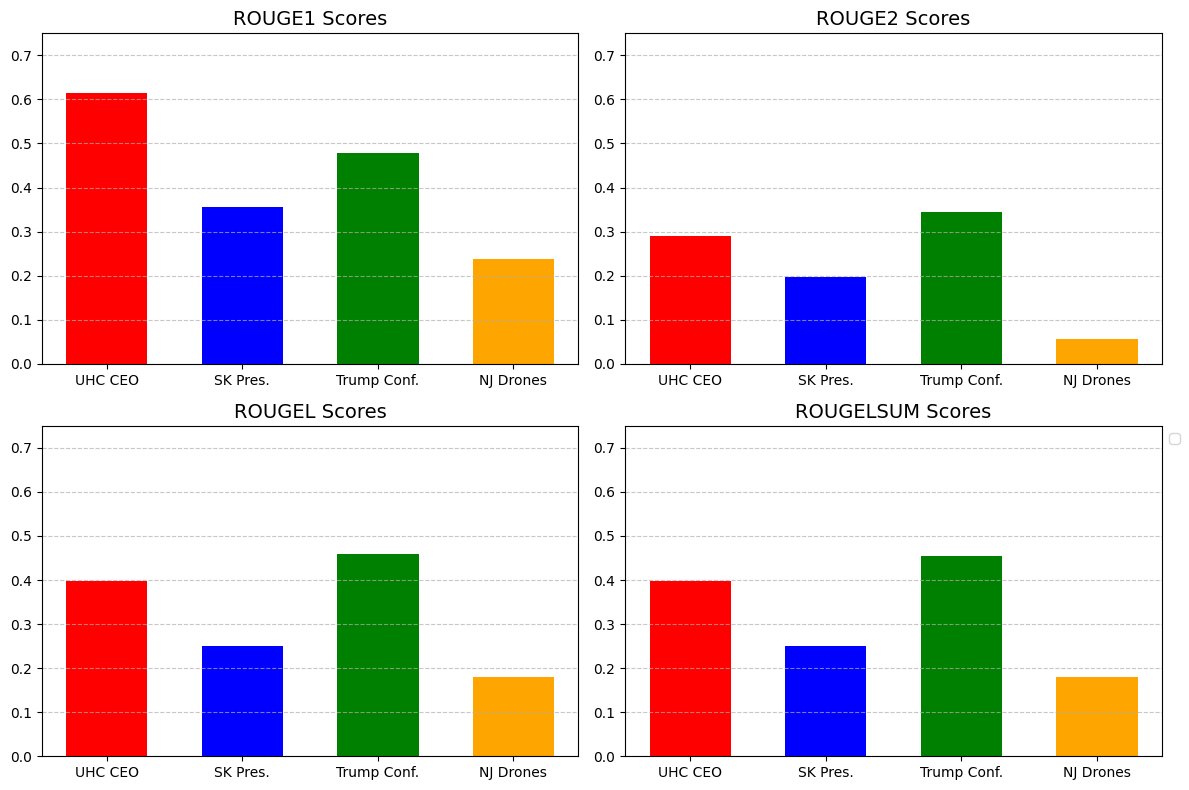

In [50]:
rouge_scores = [rouge_scores_1, rouge_scores_2, rouge_scores_3, rouge_scores_4]

keys = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
values = {key: [d[key] for d in rouge_scores] for key in keys}

topics = ['UHC CEO', 'SK Pres.', 'Trump Conf.', 'NJ Drones']

x = np.arange(len(rouge_scores))
bar_width = 0.4

colors = ['red', 'blue', 'green', 'orange']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

x = np.arange(len(rouge_scores))

for i, key in enumerate(keys):
    ax = axes[i]
    for j in range(len(rouge_scores)):
        ax.bar(
            x[j],
            values[key][j],
            color=colors[j],
            width=0.6,
            label=f'Set {j+1}' if i == 0 else ""
        )
    ax.set_title(f'{key.upper()} Scores', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([topic for topic in topics])
    ax.set_ylim(0, 0.75)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    if i == 3:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

### Double Topic Conversations

In [ ]:
queries_5 = ["Who shot the UHC CEO?",
             "Where was he shot?",
             "Where was the suspect found?",
             "How did people react?",
             'When was President Yoon impeached',
             'Who impeached him',
             'Why was he impeached',
             'What was the public’s reaction']
outputs_5 = []
labels_5 = ["Luigi Mangione, a 26 year old Ivy League graduate, shot Brian Thompson, the CEO of UnitedHealthcare",
            "Brian Thompson was shot in New York City in Midtown Manhattan outside of the Hilton hotel",
            "Luigi Mangione was found at a McDonald's restaurant in Altoona, Pennsylvania with a fake ID, firearm, and manifesto after being recognized",
            "People reacted with dark humor, critical commentary, sharing memes, jokes, and personal stories, criticism of the healthcare system, and anger and outrage towards health insurers",
            'President Yoon Suk Yeol was impeached on December 14, 2024.',
            'South Korean lawmakers in the National Assembly impeached President Yoon Suk Yeol.',
            'President Yoon Suk Yeol was impeached due to his declaration of martial law.',
            'There were widespread protests. Thousands of protestors celebrated the result of the impeachment vote and viewed it as a victory for democracy.']

model_5 = DualRagModel(logging='quiet', model='gpt')

for query in queries_5:
    outputs_5.append(model_5.generate_response(query))

In [ ]:
for output in outputs_5:
    print(output)

In [ ]:
rouge_scores_5 = rouge.compute(predictions=outputs_5, references=labels_5)

print("ROUGE Scores:")
for key, value in rouge_scores_5.items():
    print(f"{key}: {value:.4f}")

In [ ]:
queries_6 = ['When was President Yoon impeached',
             'Who impeached him',
             'Why was he impeached',
             'What was the public’s reaction',
             'When was Trump’s first conference after the election held',
             'Who did he nominate as attorney general',
             'Who did he nominate for Secretary of State',
             'Who is he replacing as president',
             'What top executives has he met with or will meet',
             'What did he say in the conference']
outputs_6 = []
labels_6 = ['President Yoon Suk Yeol was impeached on December 14, 2024.',
            'South Korean lawmakers in the National Assembly impeached President Yoon Suk Yeol.',
            'President Yoon Suk Yeol was impeached due to his declaration of martial law.',
            'There were widespread protests. Thousands of protestors celebrated the result of the impeachment vote and viewed it as a victory for democracy.',
            'Donald Trump’s first press conference after the election was held at Mar-a-Lago.',
            'Donald Trump nominated Pam Bondi for attorney general.',
            'Donald Trump nominated Marco Rubio for Secretary of State.',
            'Donald Trump is replacing Joe Biden as president.',
            'Donald Trump will meet with Mark Zuckerburg, Tim Cook, Sundar Pichai, and Jeff Bezos.',
            "He discussed SoftBank's $100 billion investment plan in U.S. projects, the Ukraine war, border wall construction and potential legal action, New York Mayor Eric Adams' legal troubles, his transition process and meetings with business leaders, and drones in New Jersey."]

model_6 = DualRagModel(logging='quiet', model='gpt')

for query in queries_6:
    outputs_6.append(model_6.generate_response(query))

In [ ]:
for output in outputs_6:
    print(output)

In [ ]:
rouge_scores_6 = rouge.compute(predictions=outputs_6, references=labels_6)

print("ROUGE Scores:")
for key, value in rouge_scores_6.items():
    print(f"{key}: {value:.4f}")

In [ ]:
queries_7 = ['When was Trump’s first conference after the election held',
             'Who did he nominate as attorney general',
             'Who did he nominate for Secretary of State',
             'Who is he replacing as president',
             'What top executives has he met with or will meet',
             'What did he say in the conference',
             'Why have drones been in the headlines',
             'Were they deployed by the US military',
             'Are they a threat']
outputs_7 = []
labels_7 = ['Donald Trump’s first press conference after the election was held at Mar-a-Lago.',
            'Donald Trump nominated Pam Bondi for attorney general.',
            'Donald Trump nominated Marco Rubio for Secretary of State.',
            'Donald Trump is replacing Joe Biden as president.',
            'Donald Trump will meet with Mark Zuckerburg, Tim Cook, Sundar Pichai, and Jeff Bezos.',
            "He discussed SoftBank's $100 billion investment plan in U.S. projects, the Ukraine war, border wall construction and potential legal action, New York Mayor Eric Adams' legal troubles, his transition process and meetings with business leaders, and drones in New Jersey.",
            'There have been sightings of mysterious drones flying over New Jersey at night. There is no evidence of malicious activity or foreign involvement.',
            'No they are not military drones.',
            'The drones are not a threat to public safety or national security. Most of the sightings are misidentified legal aircraft and stars.']

model_7 = DualRagModel(logging='quiet', model='gpt')

for query in queries_7:
    outputs_7.append(model_7.generate_response(query))

In [ ]:
for output in outputs_7:
    print(output)

In [ ]:
rouge_scores_7 = rouge.compute(predictions=outputs_7, references=labels_7)

print("ROUGE Scores:")
for key, value in rouge_scores_7.items():
    print(f"{key}: {value:.4f}")

In [ ]:
queries_8 = ['Why have drones been in the headlines',
             'Were they deployed by the US military',
             'Are they a threat',
             "Who shot the UHC CEO?",
             "Where was he shot?",
             "Where was the suspect found?",
             "How did people react?"]
outputs_8 = []
labels_8 = ['There have been sightings of mysterious drones flying over New Jersey at night. There is no evidence of malicious activity or foreign involvement.',
            'No they are not military drones.',
            'The drones are not a threat to public safety or national security. Most of the sightings are misidentified legal aircraft and stars.',
            "Luigi Mangione, a 26 year old Ivy League graduate, shot Brian Thompson, the CEO of UnitedHealthcare",
            "Brian Thompson was shot in New York City in Midtown Manhattan outside of the Hilton hotel",
            "Luigi Mangione was found at a McDonald's restaurant in Altoona, Pennsylvania with a fake ID, firearm, and manifesto after being recognized",
            "People reacted with dark humor, critical commentary, sharing memes, jokes, and personal stories, criticism of the healthcare system, and anger and outrage towards health insurers"]

model_8 = DualRagModel(logging='quiet', model='gpt')

for query in queries_8:
    outputs_8.append(model_8.generate_response(query))

In [ ]:
for output in outputs_8:
    print(output)

In [ ]:
rouge_scores_8 = rouge.compute(predictions=outputs_8, references=labels_8)

print("ROUGE Scores:")
for key, value in rouge_scores_8.items():
    print(f"{key}: {value:.4f}")

In [ ]:
rouge_scores = [rouge_scores_5, rouge_scores_6, rouge_scores_7, rouge_scores_8]

keys = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
values = {key: [d[key] for d in rouge_scores] for key in keys}

topics = ['UHC CEO \n+ SK Pres.', 'SK Pres. \n+ Trump Conf.', 'Trump Conf. \n+ NJ Drones', 'NJ Drones \n+ UHC CEO']

x = np.arange(len(rouge_scores))
bar_width = 0.4

colors = ['red', 'blue', 'green', 'orange']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

x = np.arange(len(rouge_scores))

for i, key in enumerate(keys):
    ax = axes[i]
    for j in range(len(rouge_scores)):
        ax.bar(
            x[j],
            values[key][j],
            color=colors[j],
            width=0.6,
            label=f'Set {j+1}' if i == 0 else ""
        )
    ax.set_title(f'{key.upper()} Scores', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([topic for topic in topics])
    ax.set_ylim(0, 0.5)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    if i == 3:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()